<a href="https://colab.research.google.com/github/manu6521/Image_project/blob/main/CNN_LSTM_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import modules


In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,LSTM,Dense,Embedding,Dropout,concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Reshape
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu


In [2]:
pip install transformers torch torchvision

In [3]:

!pip install pydot

In [4]:
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!mkdir -p /content/flickr_new


In [6]:

!unzip '/content/drive/MyDrive/flicker/Flickr8k_Dataset.zip' -d /content/flickr_new


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: /c

In [7]:
dir_new = '/content/flickr_new/Flicker8k_Dataset/'
dir_cap = '/content/flickr_new/'

In [8]:
#printing number of images
df = os.listdir(dir_new)
print(len(df))

8091


In [9]:
#model
model = VGG16()
model = Model(inputs = model.inputs,outputs = model.layers[-2].output)
print(model.summary())


553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [10]:
#extract features from image
features = { }
for img_name in tqdm(os.listdir(dir_new)):
  #load image from file
  image_path = dir_new + '/' + img_name
  image = load_img(image_path, target_size=(224,224))
  # convert image pixels to numpy array
  image = img_to_array(image)
  #reshape data for model
  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  #preprocess image for vgg16
  image = preprocess_input(image)
  #extract feature
  feature = model.predict(image,verbose=0)
  #get image id
  image_id = img_name.split('.')[0]
  #store features
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [11]:

#store features in pickle
pickle.dump(features, open(os.path.join(dir_new, 'ex_features.pkl'), 'wb'))

In [12]:
# load feature from pickle
with open(os.path.join(dir_new, 'ex_features.pkl'), 'rb') as f:
  ex_features = pickle.load(f)


In [13]:
#### TESTING

def print_image_features(features_dict):
    for key, value in features_dict.items():
        print(f"Image ID: {key}")
        print(f"Features: {value}")
        print(f"Feature shape: {np.array(value).shape}")
        print("-" * 50)

# Print the values in the dictionary
#print_image_features(ex_features)

In [14]:
!unzip '/content/drive/MyDrive/captions.txt.zip' -d /content/flickr_new

Archive:  /content/drive/MyDrive/captions.txt.zip
  inflating: /content/flickr_new/captions.txt  


In [15]:
with open(os.path.join(dir_cap, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()





In [16]:
#create mapping of images to captions
mapping = { }
# process line
for line in tqdm(captions_doc.split('\n')):
#split line by comma
  tokens = line.split(',')
  if len(line)<2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extension from image id
  image_id = image_id.split('.')[0]
  # convert caption list to a string
  caption = " ".join(caption)
  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

print(mapping[image_id])

  0%|          | 0/40456 [00:00<?, ?it/s]

['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


In [17]:
# preprocess caption
def clean_cap(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      # convert to lowercase
      caption = caption.lower()
      # deleting special chars, digits
      caption = caption.replace('[^A-Za-z]','')
      # removing additional spaces
      caption = caption.replace('\s+',' ')
      # add <start> and <end> tag
      caption = " ".join([word for word in caption.split() if len(word)>1])
      caption = 'start ' + caption + ' end'
      captions[i] = caption




In [18]:
# before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
# calling cleaning function
clean_cap(mapping)

In [20]:
# after preprocessing"
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [21]:
# saving all the caption in single list
final_captions = []
for key in mapping:
  for caption in mapping[key]:
    final_captions.append(caption)

In [22]:
len(final_captions)

40455

In [23]:
# text tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8483


In [24]:
#findimg maximum length of caption
length_max = max(len(caption.split()) for caption in final_captions)
length_max

35

## Train_test_split

In [25]:

image_ids = list(mapping.keys())


In [26]:
from sklearn.model_selection import train_test_split
train_keys, temp_keys = train_test_split(image_ids, test_size=0.3, random_state=42)
val_keys, test_keys = train_test_split(temp_keys, test_size=0.1, random_state=42)


In [27]:
print('Length of train is ' + str(len(train_keys)))
print('Length of test is ' + str(len(test_keys)))
print('Length of val is ' + str(len(val_keys)))

Length of train is 5663
Length of test is 243
Length of val is 2185


In [28]:
## Create generator to get data in batch

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # Split the sequence into input and output pairs
                    input_seq, output_seq = seq[:i], seq[i]
                    # Pad the input sequence to max_length
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    # One-hot encode the output sequence
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(input_seq)
                    y.append(output_seq)
                    # Yield a batch of data
                    if len(X1) == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = [], [], []



## CREATING MODEL

In [29]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)


inputs2 = Input(shape = (length_max,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')


plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
train_losses = []
val_losses = []

epochs = 30
batch_size = 64
train_steps = len(train_keys) // batch_size
val_steps = len(val_keys) // batch_size
test_steps = len(test_keys) // batch_size

In [31]:
train_generator = data_generator(train_keys, mapping, ex_features, tokenizer, length_max, vocab_size, batch_size)
val_generator = data_generator(val_keys, mapping, ex_features, tokenizer, length_max, vocab_size, batch_size)
test_generator = data_generator(test_keys, mapping, ex_features, tokenizer, length_max, vocab_size, batch_size)

# Train the model and validate
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=train_steps, verbose=1,
                    validation_data=val_generator, validation_steps=val_steps)


Epoch 1/30
88/88 [==============================] - 15s 129ms/step - loss: 6.6349 - val_loss: 5.9201
Epoch 2/30
88/88 [==============================] - 10s 114ms/step - loss: 6.0400 - val_loss: 5.9300
Epoch 3/30
88/88 [==============================] - 10s 115ms/step - loss: 5.7304 - val_loss: 5.5309
Epoch 4/30
88/88 [==============================] - 10s 115ms/step - loss: 5.5131 - val_loss: 5.6867
Epoch 5/30
88/88 [==============================] - 10s 116ms/step - loss: 5.5530 - val_loss: 5.6333
Epoch 6/30
88/88 [==============================] - 10s 114ms/step - loss: 5.3599 - val_loss: 5.5933
Epoch 7/30
88/88 [==============================] - 10s 115ms/step - loss: 5.3190 - val_loss: 5.2507
Epoch 8/30
88/88 [==============================] - 10s 116ms/step - loss: 5.2607 - val_loss: 5.1363
Epoch 9/30
88/88 [==============================] - 10s 116ms/step - loss: 5.2619 - val_loss: 5.2040
Epoch 10/30
88/88 [==============================] - 10s 115ms/step - loss: 4.9162 - val_lo

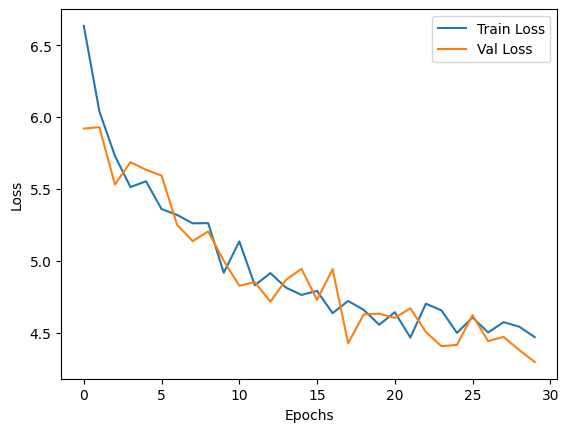

In [32]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
#converting index to word
def ind_to_word(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None





In [34]:
# generating captions
def predict_caption(model, image, tokenizer, length_max):
  in_text = 'start'
  for i in range(length_max):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], length_max)
    yhat = model.predict([image, sequence], verbose=0)

    yhat = np.argmax(yhat)

    word = ind_to_word(yhat,tokenizer)
    if word is None:
      break

    in_text += " " + word
    if word == 'end':
      break
  return in_text





In [73]:
pip install nltk


In [76]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: This downloads additional WordNet data needed for some languages


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [77]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm

# Ensure that nltk data (like punkt for sentence splitting) is downloaded
nltk.download('punkt')

actual, predicted = list(), list()
meteor_scores = []

for key in tqdm(test_keys):
    captions = mapping[key]
    y_pred = predict_caption(model, ex_features[key], tokenizer, length_max)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

    # Calculate METEOR score for each image
    for actual_caption in captions:
        # Tokenize both the reference and hypothesis
        tokenized_actual = actual_caption.split()  # Tokenize the actual caption
        tokenized_pred = y_pred  # `y_pred` is already tokenized by `split()`

        score = meteor_score([tokenized_actual], tokenized_pred)
        meteor_scores.append(score)

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# Calculate and print the average METEOR score
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score: %f" % average_meteor_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 243/243 [03:09<00:00,  1.28it/s]

BLEU-1: 0.541365
BLEU-2: 0.298972
Average METEOR Score: 0.224328


In [36]:
## Visualize

In [37]:
!pip install gtts

In [38]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=a968bcb1a1c98454d6bb4ac489b3670b445adfb2aadf22b2aa568e6ad09431a7
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Success

In [39]:
from PIL import Image
from gtts import gTTS
from googletrans import Translator
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import os

def generate_captions(image_name, language='en', speech_language='en'):
    # Initialize the translator
    translator = Translator()

    # Extract the image ID from the file name
    image_id = image_name.split('.')[0]

    # Construct the full image path
    image_path = os.path.join(dir_new, image_name)

    # Load the image
    image = Image.open(image_path)

    # Get the captions from the mapping (if needed)
    captions = mapping.get(image_id, [])

    # Generate the predicted caption
    y_pred = predict_caption(model, features[image_id], tokenizer, length_max)
    y_pred = y_pred.replace('start', '').replace('end', '').strip()

    # Translate the predicted caption to the desired language
    translated_caption = translator.translate(y_pred, dest=language).text

    # Display the translated caption
    print('...........Predicted.............')
    print(translated_caption)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

    # Convert the translated caption to speech in the specified speech language
    tts = gTTS(text=translated_caption, lang=speech_language)

    # Save the speech to an MP3 file
    output_path = "Predicted_audio.mp3"
    tts.save(output_path)

    # Display and play the audio file in the notebook
    display(Audio(output_path, autoplay=True))



...........Predicted.............
man in blue shirt is in the water


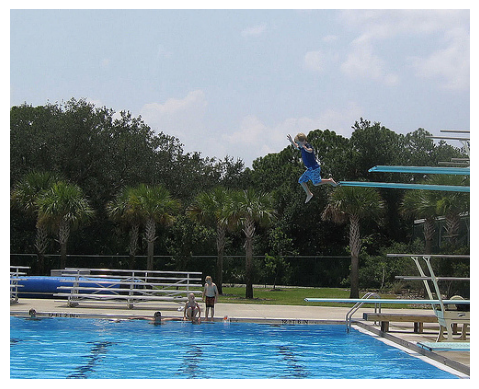

In [43]:
generate_captions('1057089366_ca83da0877.jpg', language='en', speech_language='en')

...........Predicted.............
El perro corre en la hierba


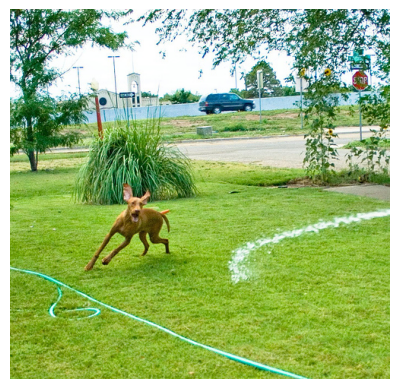

In [50]:
generate_captions('1019077836_6fc9b15408.jpg', language='es', speech_language='es')

...........Predicted.............
man in blue shirt is in the water


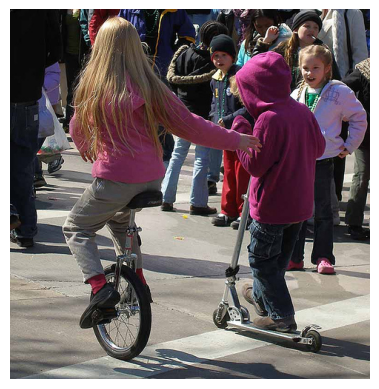

In [51]:
generate_captions('1193116658_c0161c35b5.jpg', language='en', speech_language='en')

...........Predicted.............
two people are playing in the water


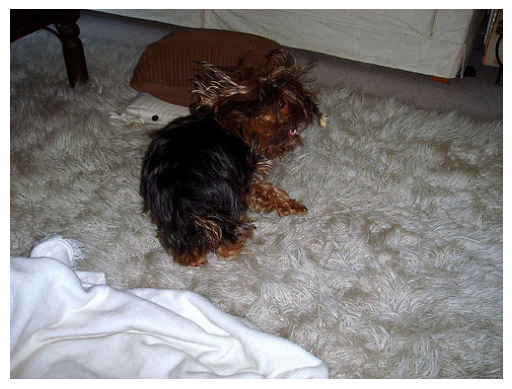

In [52]:
generate_captions('1244140539_da4804d828.jpg', language='en', speech_language='en')

...........Predicted.............
group of people are are are standing in the street


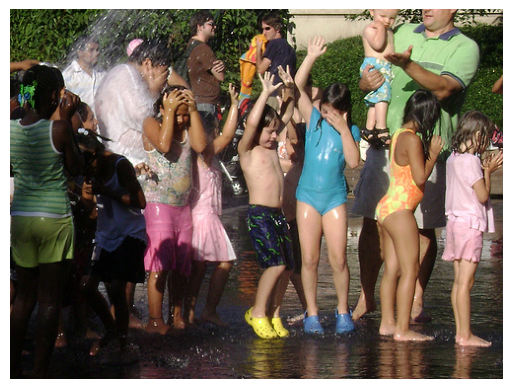

In [54]:
generate_captions('1273001772_1585562051.jpg', language='en', speech_language='en')

...........Predicted.............
the black dog is running in the water


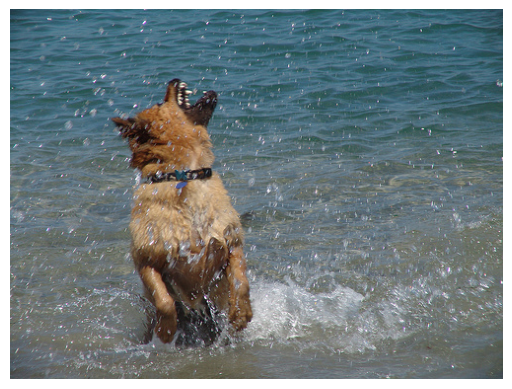

In [55]:
generate_captions('1287982439_6578006e22.jpg', language='en', speech_language='en')

...........Predicted.............
woman in the shirt is in the water


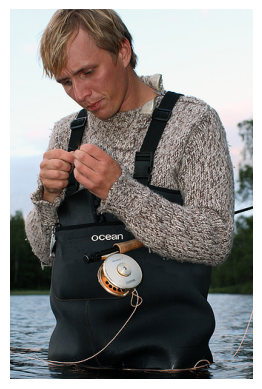

In [57]:
generate_captions('937559727_ae2613cee5.jpg', language='en', speech_language='en')

In [56]:
print(test_keys)

['937559727_ae2613cee5', '1440024115_129212c988', '3314180199_2121e80368', '3381788544_2c50e139dd', '3046286572_d2050ab0d9', '1355450069_c0675b0706', '1564614124_0ee6799935', '2400958566_4e09424046', '930126921_1b94605bdc', '3286198467_8880be127e', '3497502407_ec566442c9', '410422753_de506155fa', '617038406_4092ee91dd', '3527715826_ea5b4e8de4', '241031254_0c6f30e3d1', '3056530884_27766059bc', '148512773_bae6901fd6', '3375534917_62350bd06b', '3106782647_b078830a9e', '3123770450_cedc16d162', '2393410666_b8c20fff61', '207731022_988f6afb35', '2393971707_bce01ae754', '3724623861_2bb6c23641', '3392019836_c7aeebca1c', '3042484940_0975a5e486', '185057637_e8ada37343', '256958382_b9006bfc5b', '3532194771_07faf20d76', '783353797_fdf91bdf4c', '3486324591_9f5eeb24b9', '3600221224_945df01247', '3515358125_9e1d796244', '3587781729_bd21ce7b11', '3659686168_49c3abcee1', '2943384009_c8cf749181', '1000268201_693b08cb0e', '483841513_e660391880', '2642474867_4e6346f809', '1347519824_e402241e4f', '324973812

...........Predicted.............
two people are playing in the grass


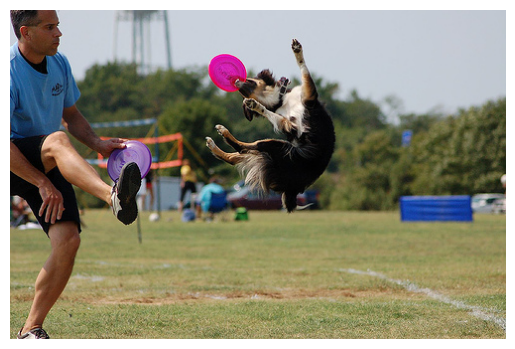

In [58]:
generate_captions('1440024115_129212c988.jpg', language='en', speech_language='en')

...........Predicted.............
boy in red shirt is playing in the air


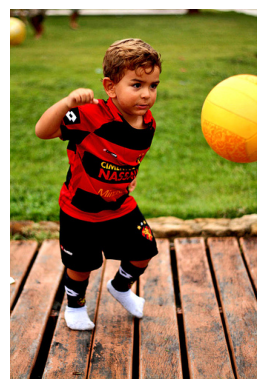

In [59]:
generate_captions('3314180199_2121e80368.jpg', language='en', speech_language='en')

...........Predicted.............
woman in the shirt and black shirt and black shirt and black shirt and woman in the camera


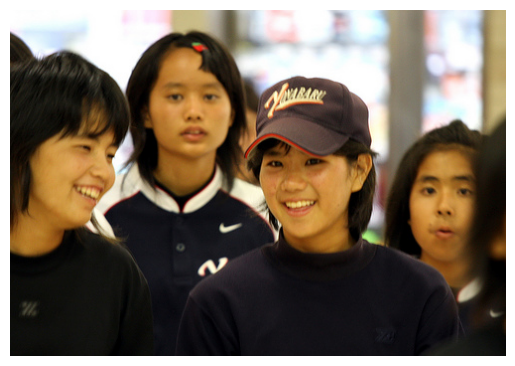

In [60]:
generate_captions('3381788544_2c50e139dd.jpg', language='en', speech_language='en')

...........Predicted.............
man in the red shirt is in the air


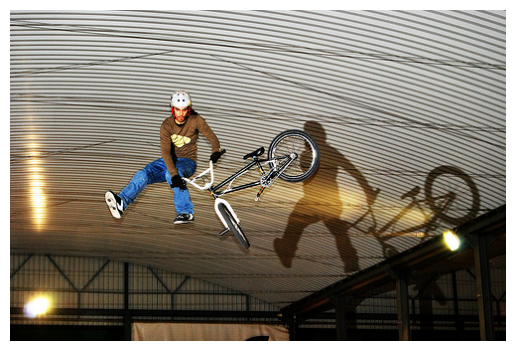

In [61]:
generate_captions('3046286572_d2050ab0d9.jpg', language='en', speech_language='en')

...........Predicted.............
man in blue shirt is in the water


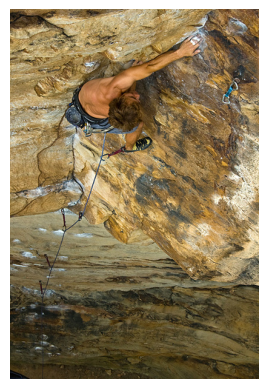

In [62]:
generate_captions('1355450069_c0675b0706.jpg', language='en', speech_language='en')

...........Predicted.............
two people are playing in the snow


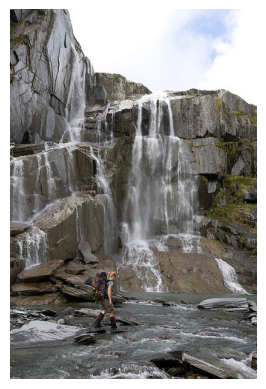

In [63]:
generate_captions('2400958566_4e09424046.jpg', language='en', speech_language='en')

...........Predicted.............
woman in the shirt is in the water


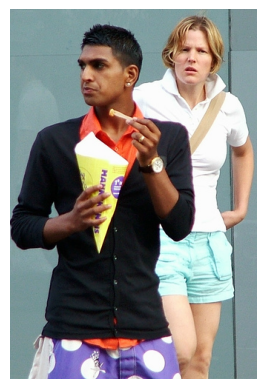

In [64]:
generate_captions('930126921_1b94605bdc.jpg', language='en', speech_language='en')

...........Predicted.............
the people is playing in the snow


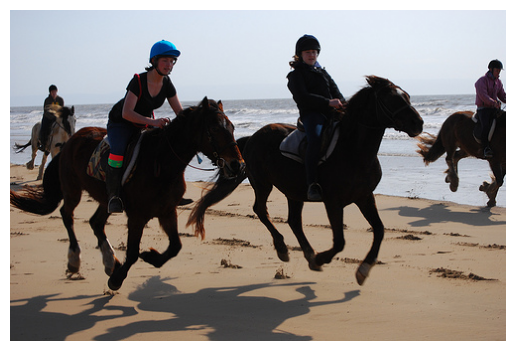

In [66]:
generate_captions('3375534917_62350bd06b.jpg', language='en', speech_language='en')

...........Predicted.............
two dogs are running in the snow


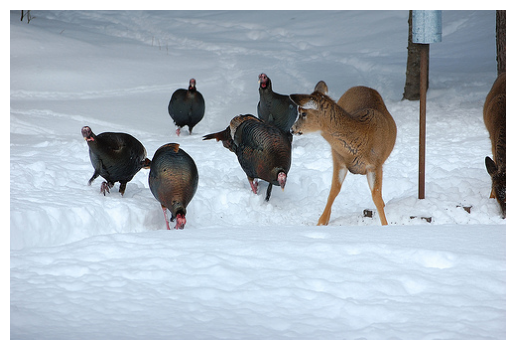

In [67]:
generate_captions('3123770450_cedc16d162.jpg', language='en', speech_language='en')

...........Predicted.............
the woman is in the water


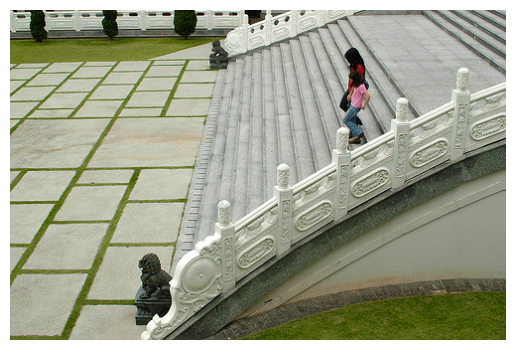

In [68]:
generate_captions('2393971707_bce01ae754.jpg', language='en', speech_language='en')

...........Predicted.............
two dogs are running in the grass


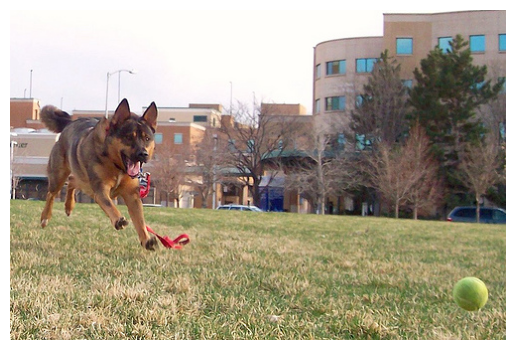

In [70]:
generate_captions('3515358125_9e1d796244.jpg', language='en', speech_language='en')

...........Predicted.............
man in the snow is in the snow


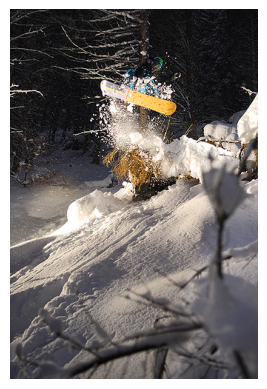

In [71]:
generate_captions('3309042087_ee96d94b8a.jpg', language='en', speech_language='en')

...........Predicted.............
two dogs are are playing


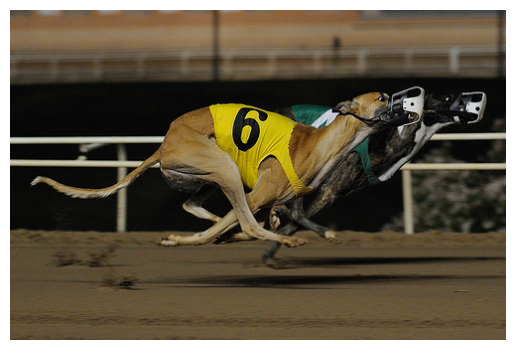

In [72]:
generate_captions('2968182121_b3b491df85.jpg', language='en', speech_language='en')